# Gauss-Jordan method

In [1]:
import numpy as np
from time import time

In [12]:
def gauss_jordan(matrix, free_terms):
    # making augmented matrix
    aug_matrix = np.zeros((matrix.shape[0], matrix.shape[0]+1))
    aug_matrix[:, matrix.shape[0]] = free_terms
    aug_matrix[:, :-1] = matrix

    # to maintain information about order of the unknowns
    columns_order = [i for i in range(aug_matrix.shape[0])]
    for i in range(aug_matrix.shape[0]):
        # full pivoting
        piv_row = i
        piv_col = i

        for row in range(i, aug_matrix.shape[0]):
            for col in range(i, aug_matrix.shape[0]):
                (piv_row, piv_col) = (row, col) if abs(aug_matrix[row, col]) > abs(aug_matrix[piv_row, piv_col])\
                    else (piv_row, piv_col)

        # swapping rows and columns to have pivot at the top left corner
        aug_matrix[[i, piv_row]] = aug_matrix[[piv_row, i]]
        aug_matrix.T[[i, piv_col]] = aug_matrix.T[[piv_col, i]]
        columns_order[i], columns_order[piv_col] = columns_order[piv_col], columns_order[i]

        # scaling
        aug_matrix[i:] /= aug_matrix[i][i]

        # Gauss elimination
        for row in [r for r in range(0, len(aug_matrix))
                    if r != i]:
            aug_matrix[row, i:] -= aug_matrix[row, i]*aug_matrix[i, i:]

    # getting order of result
    result = np.ones((1, aug_matrix.shape[0]))
    for i in range(aug_matrix.shape[0]):
        result[0, columns_order[i]] = aug_matrix[i, aug_matrix.shape[1] - 1]

    return result.T

In [58]:
def compare_functions(matrix_size, epsilon):
    """ Comparing my implementation of Gauss-Jordan algorithm with numpy's linalg.solve.
    Printing time of run for both algorithms for matrix of size passed by parameter 'matrix_size'
    and check if they have the same results with accuracy equal 'epsilon'.
    
    """
    matrix = np.random.rand(matrix_size, matrix_size)
    free_terms = np.random.rand(1, matrix_size)

    start_time = time()
    result_1 = gauss_jordan(matrix, free_terms)
    print("my algorithm took: ", time() - start_time, "\n")

    start_time = time()
    result_2 = np.linalg.solve(matrix, free_terms.T)
    print("numpy algorithm took: ", time() - start_time, "\n")

    same = True
    comparison = abs(result_1 - result_2) < epsilon

    for i in comparison.T[0]:
        if not i:
            same = False
            break
            
    if same:
        print("Functions have the same results with accuracy {}".format(epsilon))
    else:
        print("Functions have different results")

In [60]:
epsilon = 10 ** (-10)

compare_functions(510, epsilon)
# ~25s to ~0.006s

my algorithm took:  25.895076036453247 

numpy algorithm took:  0.006154298782348633 

Functions have the same results with accuracy 1e-10


In [61]:
compare_functions(600, epsilon)
# ~46s to ~0.008s

my algorithm took:  46.31980562210083 

numpy algorithm took:  0.008476972579956055 

Functions have the same results with accuracy 1e-10


In [62]:
compare_functions(750, epsilon)
# ~99s to ~0.012s

my algorithm took:  99.24010944366455 

numpy algorithm took:  0.011631250381469727 

Functions have the same results with accuracy 1e-10


# LU factorization

In [94]:
import scipy.linalg

In [100]:
def lu_factorization(matrix):
    """Decomposition matrix to matrices p, l, u with partial pivoting."""
    n = matrix.shape[0]
    p_matrix = np.identity(n)
    for i in range(n):
        # partial pivoting
        piv = i
        for row in range(i + 1, n):
            piv = row if abs(matrix[row][i]) > abs(matrix[piv][i]) else piv

        # swapping rows to have pivot at the top left corner
        matrix[[piv, i]] = matrix[[i, piv]]
        p_matrix[[piv, i]] = p_matrix[[i, piv]]

        # Gauss elimination
        for row in range(i + 1, matrix.shape[0]):
            matrix[row, i + 1:] -= matrix[row, i] / matrix[i, i] * matrix[i, i + 1:]
            matrix[row][i] = matrix[row, i] / matrix[i, i]

    l_matrix = np.tril(matrix)
    u_matrix = np.triu(matrix)
    for i in range(matrix.shape[0]):
        l_matrix[i][i] = 1
        
    return p_matrix.T, l_matrix, u_matrix

        
def check_correctness(a, p, l, u, epsilon):
    """Checking if the result of decomposition of matrix a is the same as using scipy.linalg.lu function 
    and if p @ l @ u == a with accuracy equal to passed 'epsilon'.
    """
    scipy_p, scipy_l, scipy_u = scipy.linalg.lu(a.copy())

    correct_p = abs(p - scipy_p) < epsilon
    correct_l = abs(l - scipy_l) < epsilon
    correct_u = abs(u - scipy_u) < epsilon

    correct = abs(a - p @ l @ u) < epsilon

    if np.all(correct_p) and np.all(correct_l) and np.all(correct_u) and np.all(correct):
        print("Decomposition is correct with accuracy {}".format(epsilon))
    else:
        print("Decomposition is incorrect")

In [101]:
epsilon = 10 ** (-7)

In [102]:
matrix = np.random.rand(500, 500)
p, l, u = lu_factorization(matrix.copy())
check_correctness(matrix, p, l, u, epsilon)

Decomposition is correct with accuracy 1e-07


In [103]:
matrix = np.random.rand(750, 750)
p, l, u = lu_factorization(matrix.copy())
check_correctness(matrix, p, l, u, epsilon)

Decomposition is correct with accuracy 1e-07


# Circuit analysis (nodal analysis)

In [80]:
import networkx as nx
import random
import matplotlib.pyplot as plt

### Functions

In [112]:
def get_random(n):
    """Getting random connected graph."""
    while True:
        graph = nx.erdos_renyi_graph(n, 0.5)
        if nx.is_connected(graph):
            return graph


def get_cubic(n):
    """Getting cubic graph."""
    return nx.random_regular_graph(3, n)


def get_with_bridge(n):
    """Getting a graph which consists of two random connected graphs and a bridge between them."""
    div = random.randint(3, n-3)
    tmp_graph_1 = nx.gnm_random_graph(div, random.randint(div-1, div*(div-1)/2))
    while not nx.is_connected(tmp_graph_1):
        tmp_graph_1 = nx.gnm_random_graph(div, random.randint(div - 1, div * (div - 1) / 2))

    tmp_graph_2 = nx.gnm_random_graph(n-div, random.randint(n-div-1, (n-div)*(n-div-1)/2))
    while not nx.is_connected(tmp_graph_2):
        tmp_graph_2 = nx.gnm_random_graph(n - div, random.randint(n - div - 1, (n - div) * (n - div - 1) / 2))

    graph = nx.empty_graph(n)

    for edge in tmp_graph_1.edges:
        graph.add_edge(*edge)

    for (e_from, e_to) in tmp_graph_2.edges:
        graph.add_edge(e_from + div, e_to + div)

    bridge = (random.randint(0, div-1), random.randint(div, n-1))
    graph.add_edge(*bridge)

    return graph


def change_grid_indices(graph):
    """Changing grid graph 2-dimensional indices of nodes to one dimensional (e.g. from (2,3) to 5)"""
    grid_nodes_dict = {}

    lin_graph = nx.empty_graph()
    i = 0
    for node in graph.nodes:
        grid_nodes_dict[node] = i
        lin_graph.add_node(i)
        i += 1

    for node in grid_nodes_dict:
        for neigh in graph.neighbors(node):
            if (grid_nodes_dict[node], grid_nodes_dict[neigh]) not in lin_graph:
                lin_graph.add_edge(grid_nodes_dict[node], grid_nodes_dict[neigh])

    return lin_graph


def get_grid(x, y):
    """Getting grid graph with x*y nodes."""
    while True:
        graph = nx.grid_2d_graph(x, y)
        if nx.is_connected(graph):
            return change_grid_indices(graph)


def add_random_resistance(graph):
    """Adding random resistance from 1 to 100 to the graph edges."""
    for edge in graph.edges:
        graph.edges[edge]['R'] = random.randint(1, 100)


def save_graph_to_file(graph, s, t, e, file_path):
    """Saving graph to file.
    
    First line: s t e
    where s and are nodes between which an eletromotive force 'e' is put
    
    Second line: n m
    where n is the number of nodes in the graph and m is the number of edges in the graph
    
    Next 'm' lines: u v R
    where (u, v) is an edge in the graph with resistance equal to R
    
    """
    with open(file_path, "w+") as file:
        file.write("{} {} {}\n".format(s, t, e))
        file.write("{} {}\n".format(nx.number_of_nodes(graph), nx.number_of_edges(graph)))
        for (e_from, e_to) in graph.edges:
            file.write("{} {} {}\n".format(e_from, e_to, graph.edges[e_from, e_to]['R']))


def random_graph_to_file(function, file_path, *args):
    """Making random graph from given funciton, adding random resistance and electromotive force
    and writing it to the file which path is 'file_path'.
    """
    graph = function(*args)
    add_random_resistance(graph)
    s, t, e = get_electromotive(graph)
    save_graph_to_file(graph, s, t, e, file_path)


def swap_nodes_with_s_and_t(e_from, e_to, s, t, n,  reverse=False):
    """Swapping an index of node s with the node of index n-2 and an index of node t with the one of index n-1.
    It makes next calculations easier.
    """
    if s == n-1 and t != n-2:
        if reverse:
            if e_from == s:
                e_from = t
            elif e_from == t:
                e_from = n - 2
            elif e_from == n - 2:
                e_from = s

            if e_to == s:
                e_to = t
            elif e_to == t:
                e_to = n - 2
            elif e_to == n - 2:
                e_to = s
        else:
            if e_from == s:
                e_from = n - 2
            elif e_from == t:
                e_from = n - 1
            elif e_from == n - 2:
                e_from = t

            if e_to == s:
                e_to = n - 2
            elif e_to == t:
                e_to = n - 1
            elif e_to == n - 2:
                e_to = t

    elif t == n-2 and s != n-1:
        if reverse:
            if e_from == s:
                e_from = n - 1
            elif e_from == t:
                e_from = s
            elif e_from == n - 1:
                e_from = t

            if e_to == s:
                e_to = n - 1
            elif e_to == t:
                e_to = s
            elif e_to == n - 1:
                e_to = t
        else:
            if e_from == s:
                e_from = n - 2
            elif e_from == t:
                e_from = n - 1
            elif e_from == n - 1:
                e_from = s

            if e_to == s:
                e_to = n - 2
            elif e_to == t:
                e_to = n - 1
            elif e_to == n - 1:
                e_to = s
    else:

        if e_from == s:
            e_from = n - 2
        elif e_from == t:
            e_from = n - 1
        elif e_from == n - 2:
            e_from = s
        elif e_from == n - 1:
            e_from = t

        if e_to == s:
            e_to = n - 2
        elif e_to == t:
            e_to = n - 1
        elif e_to == n - 2:
            e_to = s
        elif e_to == n - 1:
            e_to = t

    return e_from, e_to


def load_graph_from_file(file_path, swap=True):
    """Loading graph froma given path. Swapping s, t with n-2, n-1 is optional."""
    with open(file_path) as file:
        s, t, e = map(int, file.readline().split(' '))
        n, m = map(int, file.readline().split(' '))

        graph = nx.empty_graph(n)

        for i in range(m):
            e_from, e_to, r = map(int, file.readline().split(' '))

            if swap:
                e_from, e_to = swap_nodes_with_s_and_t(e_from, e_to, s, t, n)

            graph.add_edge(e_from, e_to, R=r, I=0)

    return graph, s, t, e


def get_electromotive(graph):
    """Getting random electromotive force between random nodes."""
    n = nx.number_of_nodes(graph)

    s = random.randint(0, n-1)
    t = random.randint(0, n-1)

    if s == t:
        t = (t + 1) % (n-1)

    e = random.randint(1, 100)

    return s, t, e


def make_matrix(graph, e):
    """Building matrix of system of equations made by nodal analysis done on all nodes of graph
    except for s and t. Size of the matrix: (n-2)x(n-2)
    """
    n = nx.number_of_nodes(graph) - 2
    matrix = np.zeros((n, n))
    free_terms = np.zeros((1, n))

    for inx in range(n):
        for neigh in nx.all_neighbors(graph, inx):
            matrix[inx, inx] += 1 / graph.edges[inx, neigh]['R']

            if neigh == n+1:
                free_terms[0, inx] += e / graph.edges[inx, neigh]['R']
            elif neigh != n:
                matrix[inx, neigh] -= 1 / graph.edges[inx, neigh]['R']
            # in case of neigh == n we are adding 0 to the free terms matrix at the index of inx

    return matrix, free_terms


def results_to_intensity(graph, e, result):
    """Saving intensity of the current in every edge to that edge."""
    n = nx.number_of_nodes(graph)

    for inx in range(n-1):
        for neigh in nx.all_neighbors(graph, inx):
            if inx < neigh:
                if inx == n-2:
                    v_inx = 0
                else:
                    v_inx = result[inx, 0]

                if neigh == n-2:
                    v_neigh = 0
                elif neigh == n-1:
                    v_neigh = e
                else:
                    v_neigh = result[neigh, 0]

                graph.edges[inx, neigh]['I'] = (v_inx - v_neigh) / graph.edges[inx, neigh]['R']


def make_directed_result_graph(graph, s, t):
    """Making directed graph. If intensity is non-negative from node u to v, 
    then there is an edge between u and v.
    """
    n = nx.number_of_nodes(graph)
    di_graph = nx.DiGraph()
    for i in range(n):
        di_graph.add_node(i)

    for inx in range(n-1):
        for neigh in nx.all_neighbors(graph, inx):
            if inx < neigh:
                e_from = inx
                e_to = neigh

                e_from, e_to = swap_nodes_with_s_and_t(e_from, e_to, s, t, n, reverse=True)

                if graph.edges[inx, neigh]['I'] >= 0:
                    di_graph.add_edge(e_from, e_to, I=graph.edges[inx, neigh]['I'])
                else:
                    di_graph.add_edge(e_to, e_from, I=-1 * graph.edges[inx, neigh]['I'])

    return di_graph


def check_correctness(file_path, di_graph):
    """Checking correctness of the calculated intensity. Current going into the node must be equal 
    to that leaving the node.
    """
    graph, s, t, _ = load_graph_from_file(file_path, swap=False)
    epsilon = 10 ** (-5)

    for inx in range(graph.number_of_nodes()):
        if inx != s and inx != t:
            i_sum = 0

            for neigh in nx.neighbors(graph, inx):

                if neigh in nx.neighbors(di_graph, inx):
                    i_sum += di_graph.edges[inx, neigh]['I']
                else:
                    i_sum -= di_graph.edges[neigh, inx]['I']

            if abs(i_sum) > epsilon:
                return False

    return True


def draw_graph(graph, s, t):
    """Drawing graph with highlighting s(green) and t(red) nodes. Higher intensity in the edge is shown by 
    edge being darker.
    """
    pos = nx.spring_layout(graph)
    nodes_colors = ['#0000FF' for _ in range(graph.number_of_nodes())]
    nodes_colors[s] = '#00FF00'
    nodes_colors[t] = '#FF0000'

    _, intensity = zip(*nx.get_edge_attributes(graph, 'I').items())

    edge_labels = {}
    for key, value in nx.get_edge_attributes(graph, 'I').items():
        edge_labels[key] = "{0:.3f}".format(value)

    nx.draw_networkx_nodes(graph, pos, node_color=nodes_colors)
    nx.draw_networkx_edges(graph, pos, edge_color=intensity, edge_cmap=plt.cm.Oranges)
    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    plt.show()
    

def show_graph(path):
    graph, s, t, e = load_graph_from_file(path)

    matrix, free_terms = make_matrix(graph, e)

    result = np.linalg.solve(matrix, free_terms.T)
    results_to_intensity(graph, e, result)
    result_graph = make_directed_result_graph(graph, s, t)
    draw_graph(result_graph, s, t)

    if check_correctness(path, result_graph):
        print("Intensity on the graph is correct")
    else:
        print("Intensity on the graph is not correct")

### Making random graphs and saving them to files

In [118]:
# saving random connected graph to file
random_graph_to_file(get_random, "graphs/random.txt", 15)

In [126]:
# saving random cubic graph to file
random_graph_to_file(get_cubic, "graphs/cubic.txt", 20)

In [140]:
# saving to file a graph consisting of two random graphs which are connected by a bridge
random_graph_to_file(get_with_bridge, "graphs/bridge.txt", 15)

In [148]:
# saving random grid graph to file
random_graph_to_file(get_grid, "graphs/grid.txt", 3, 5)

### Tests

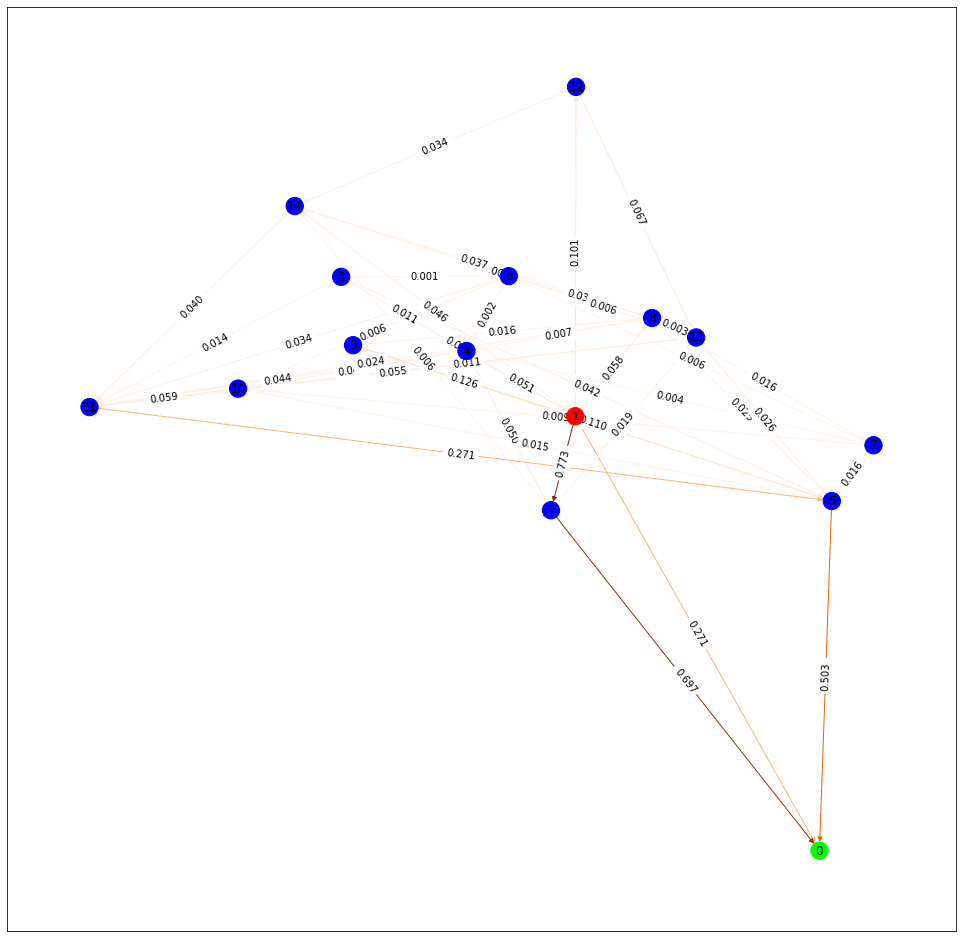

Intensity on the graph is correct


In [119]:
plt.figure(figsize=(17,17))
show_graph("graphs/random.txt")
# correctness checked for graphs of size: 15, 30, 50, 100

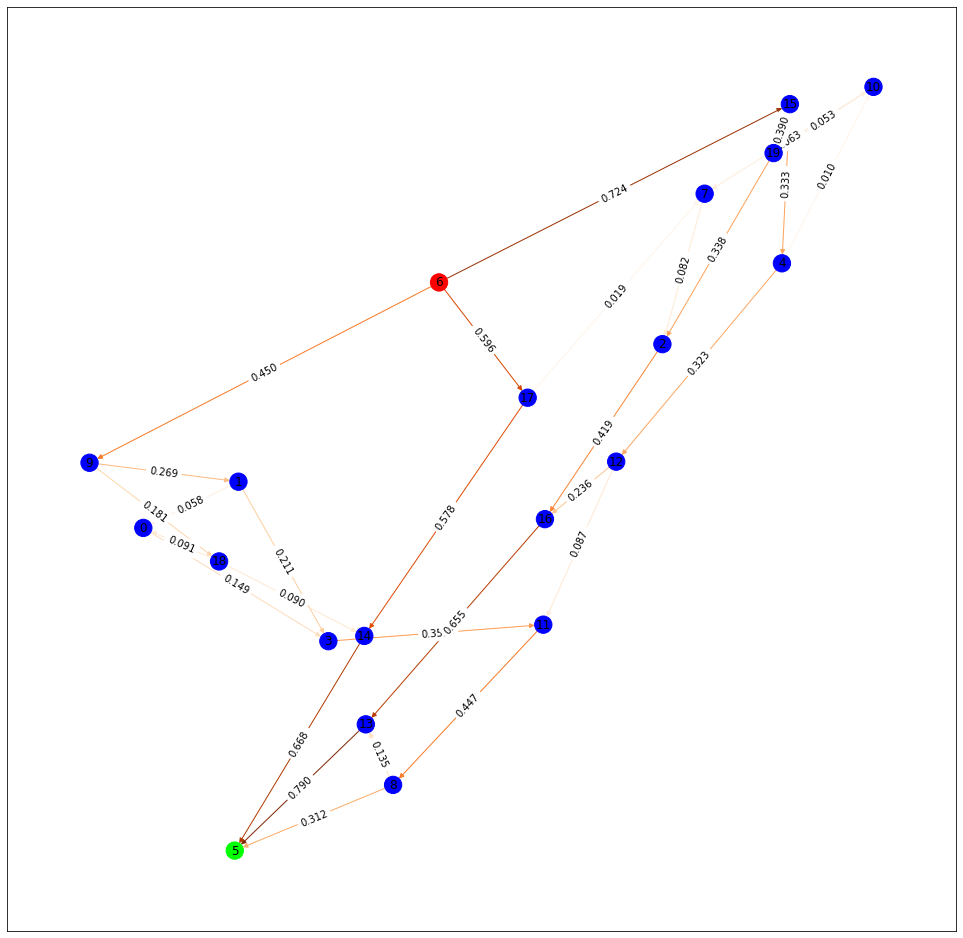

Intensity on the graph is correct


In [127]:
plt.figure(figsize=(17,17))
show_graph("graphs/cubic.txt")
# correctness checked for graphs of size: 20, 50, 100

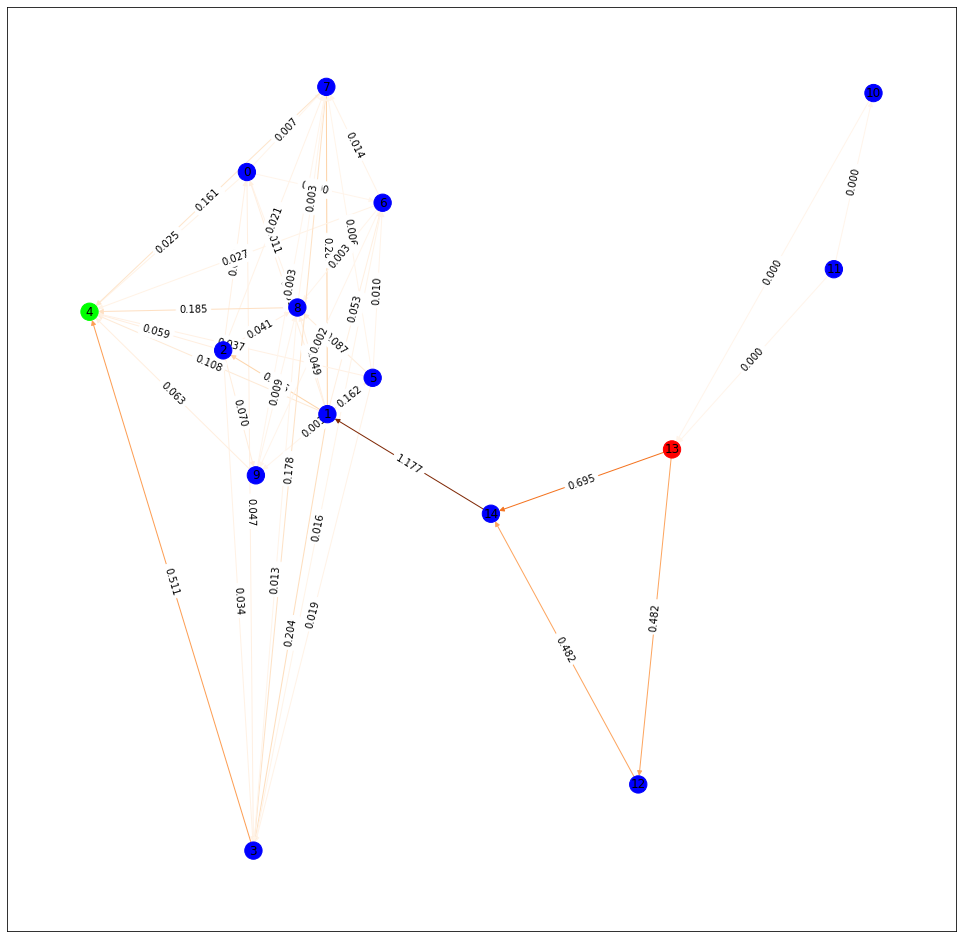

Intensity on the graph is correct


In [141]:
plt.figure(figsize=(17,17))
show_graph("graphs/bridge.txt")
# correctness checked for graphs of size: 15, 50, 100

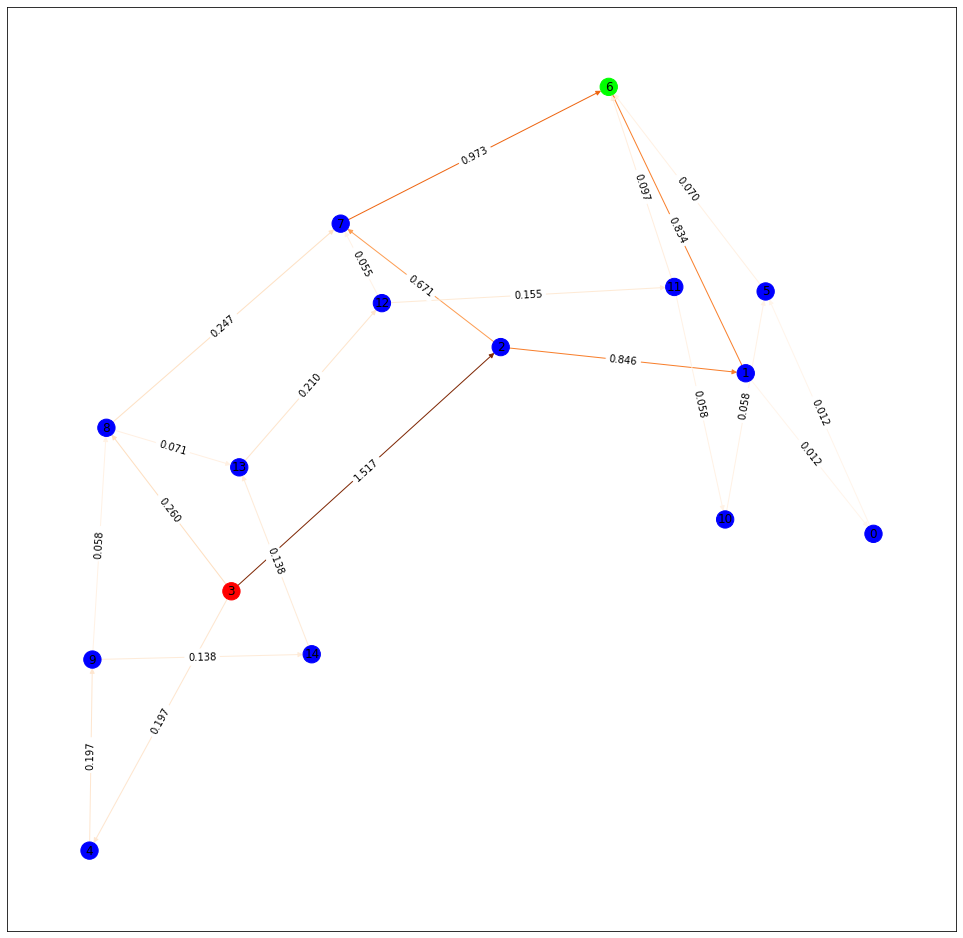

Intensity on the graph is correct


In [149]:
plt.figure(figsize=(17,17))
show_graph("graphs/grid.txt")
# correctness checked for graphs of size: 15 (3x5), 50 (5x10), 100 (10x10)